In [3]:
%run necessary_functions.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    # sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths

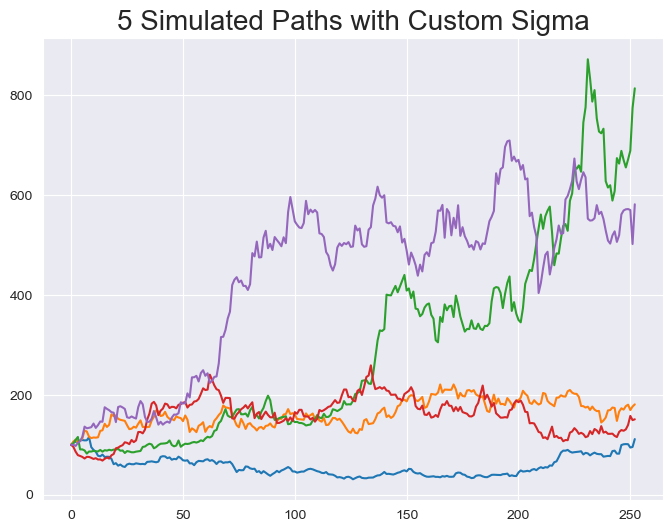

In [ ]:

def stock_path_custom_sigma(S0, t, r, mu, phi, v0, n_paths, n_steps):
    v_ar = [v0]

    noise = np.random.normal(0,1,(n_paths, n_steps))
    noise_v = np.random.normal(0,1,(n_paths, n_steps))
    for i in range(n_steps):
        v_ar.append(np.abs(v_ar[i]*phi + noise_v[:,i]))
    vt = np.array(v_ar[1:]).T
    dt = t/n_steps
    increments = (mu + r - 0.5*vt)*dt + np.sqrt(vt)*np.sqrt(dt)*noise
    log_returns = np.cumsum(increments, axis=1)
    paths = S0*np.exp(log_returns)
    paths = np.insert(paths, 0, S0, axis = 1)

    return paths

S0 = 100
t = 1
r = 0.039
mu = 1.5
n_paths = 5
n_steps = 252
phi = 0.01
v0 = 0.1

simulated_paths = stock_path_custom_sigma(S0, t, r, mu, phi, v0, n_paths, n_steps)


plt.figure(figsize = (8,6))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)

plt.show()

In [ ]:
S0 = 100
t = 1
r = 0.039
mu = 1.5
n_paths = 5
n_steps = 252
phi = 0.01
v0 = 0.1
K = 110


simulated_paths = stock_path_custom_sigma(S0, t, r, mu, phi, v0, n_paths, n_steps)
call_vals = np.maximum(simulated_paths[:,-1] - K, 0)*np.exp(-r*t)
print(np.mean(call_vals))
print(np.std(call_vals)/np.sqrt(n_paths))
print(bs_call(S0, K, v0, t, r))
bs_MC_call(S0, K, v0, t, r, mu, n_sims = 2500, n_hedges = 50, delta_sims = 250)

# plt.figure(figsize = (8,6))
# plt.hist(call_vals, density=True, bins = 30)
# plt.vlines(x = bs_call(S0, K, avg_sigma, t, r),
#             ymin=0, ymax  = 0.05, colors='r')
# plt.show()


308.58890053580365
88.74184032397862
1.8401111609266039


array([2.63730207, 3.41413613, 3.75651511, ..., 2.94776488, 2.54913354,
       2.39982434])

In [57]:
#Simulate call payouts discounted to time 0
S0 = 100
t = 1
r = 0.039
mu = 1.5
n_sims = 1000
n_steps = 252
n_hedges = n_steps
phi = 0.01
v0 = 0.1
K = 110

simulated_paths = stock_path_custom_sigma(S0, t, r, mu, phi, v0, n_sims, n_steps)

sigma = np.sqrt(v0)
path_end_points = simulated_paths[:,-1]

call_payouts = np.maximum(path_end_points - K,0)*np.exp(-r*t)



#Simulate stock profits at each interval

## profit from start to first step discounted to time 0
### We are going to cheat at the current moment in our simulation
### We will use the Black-Scholes formula to find Delta,
### We'll simulate Delta later

delta_start = bs_call_delta(S0,K,sigma,t,r)

paths_first_steps = simulated_paths[:,0]

first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*np.exp(-dt*r)

stock_profits = []

stock_profits.append(first_stock_profits)


## stock profits in intermediate steps

for i in range(1,n_hedges):
    stock_start = simulated_paths[:,i-1]
    stock_end = simulated_paths[:,i]
    tte = t-i*dt
    deltas = bs_call_delta(stock_start, K, sigma, tte, r)
    stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)
    stock_profits.append(stock_profit)
    
total_stock_profit = np.sum(stock_profits, axis = 0)

profits_hedged = call_payouts - total_stock_profit

std_err = np.std(profits_hedged)/np.sqrt(n_sims)

#Comparison of simulated value with Black-Scholes

print(f'Simulated-Black Scholes Price: ${np.mean(profits_hedged):.2f}  with {n_sims} simulations and \
{n_hedges} control variants and standard error: {std_err:.6f}')

print('------'*17)
print('------'*17)


print(f'Black Scholes Price of Call Option: ${bs_call(S0,K,sigma,t,r):.2f}')

Simulated-Black Scholes Price: $34.24  with 1000 simulations and 252 control variants and standard error: 1.176042
------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Black Scholes Price of Call Option: $10.23


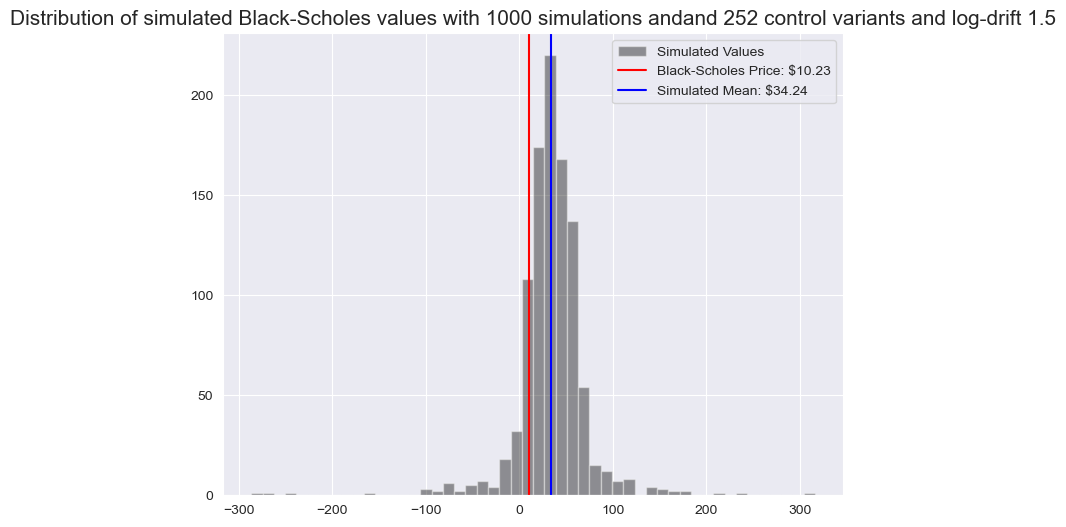

In [58]:
bs_price = bs_call(S0,K,sigma,t,r)

plt.figure(figsize = (8,6))
    
plt.hist(profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')

plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')

plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean: ${np.mean(profits_hedged):.2f}', color = 'blue')

plt.legend()
    
plt.title(f'Distribution of simulated Black-Scholes values with {n_sims} simulations and\
and {n_hedges} control variants and log-drift {mu}',size = 15)

plt.show()